In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
np.set_printoptions(suppress=True) # scientific notation gets annoying
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
import h5py
import copy

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx
from model_kit import zernike as zern
import poppy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from datetime import datetime
date_ran = datetime.now()
dr_str = date_ran.strftime("%d/%m/%Y %H:%M:%S")
print('Last date this notebook has been ran: {0}'.format(dr_str))

Last date this notebook has been ran: 15/11/2020 02:46:32


In [2]:
# initialize the data
tot_fm = 1
tot_step=4 # the last 2 step sets are bad news 
fits_folder = 'flat_mirrors/fixed_fits/'
raw_folder = 'flat_mirrors/2018_03_23/'

opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'diam_100CA': 0.019*u.m, #19*u.mm,
             'label': '19mm',
             'surf_units': u.micron,
             'fm_num': 1,
             'ring_width': 3,
             'kmid_ll': 100/u.m, #0.1/u.mm,
             'khigh_ll': 1000/u.m}# 1/u.mm}

import pickle
filename='/home/jhen/XWCL/code/MagAOX/PSD/zygo_data/zern_glue_19mm.pickle'
objects = []
with (open(filename, "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
zprj_glue = objects[0]['zern_glue']

In [9]:
# load the unglued surfaces and dust masks
nt_ptt = 3
for nf in range(0, tot_fm):
    fm_num = nf+1
    for ns in range(0, tot_step):
        surf_name = 'flat_{0}_n{1}_{2}CA_step{3}'.format(opt_parms['label'], nf+1,
                                                         opt_parms['ca'], ns)
        mask = fits.open(fits_folder+surf_name+'_bigdust_mask.fits')[0].data
        surf_fits = fits.open(fits_folder+surf_name+'_z{0}_surf.fits'.format(nt_ptt))[0]
        surf_data = surf_fits.data * mask
        surf_hdr = surf_fits.header
        
        if ns==0 and nf==0:
            opt_parms['wavelen'] = surf_hdr['wavelen'] * u.m
            opt_parms['latres'] = surf_hdr['latres'] * u.m
            opt_parms['diam_ca'] = surf_hdr['diam_ca'] * u.m
            data_set = np.zeros((tot_fm, tot_step, mask.shape[0], mask.shape[0]))
            dust_set = np.zeros((tot_fm, tot_step, mask.shape[0], mask.shape[0]))
        
        data_set[nf][ns] = surf_data
        dust_set[nf][ns] = mask
data_set = data_set * opt_parms['surf_units']

In [14]:
nt_glue = 11
zprj_diff = np.zeros((tot_step, nt_glue))
zprj_set = np.zeros((tot_step, nt_glue))
for nf in range(0, tot_fm): # choose optic
    for ns in range(0, tot_step):
        dust_mask = dust_set[nf][ns]
        test_surf = data_set[nf][ns]
        # build the Zernikes using the arbitrary basis for mask holes
        zm = poppy.zernike.arbitrary_basis(aperture=dust_mask, nterms=nt_glue, outside=0.0)

        # vectorize the mask
        vec1d = np.product(dust_mask.shape)
        mask_vec = np.reshape(dust_mask, (vec1d))
        mask_1d_coord = np.where(mask_vec==True)
        mask_vec_active = mask_vec[mask_1d_coord]
        surf_vec_active = np.reshape(test_surf,(vec1d))[mask_1d_coord]

        # change surface units from microns to radians
        data_surf = test_surf/(opt_parms['wavelen'].to(test_surf.unit)/(2*np.pi*u.radian))

        # Calculate the Zernike removal after PTT
        zprj = np.zeros((nt_glue))
        for j in range(3, nt_glue):
            # choose zernike
            zactive = np.reshape(zm[j], (vec1d))[mask_1d_coord]

            # vectorize the data
            data_vec = np.reshape(data_surf.value, (vec1d))*data_surf.unit
            data_vec_active = data_vec[mask_1d_coord]

            # calculate the dot product value based on the active regions
            dp_num=np.dot(data_vec_active, zactive)
            dp_den=np.dot(zactive, zactive)
            zprj[j] = dp_num/dp_den

            # apply dot product removal 
            data_surf = (data_surf - (zprj[j]*zm[j]*u.rad)) * dust_mask

        # convert back to surface units
        final_surf = (data_surf * (opt_parms['wavelen'].to(test_surf.unit)/(2*np.pi*u.radian))).value
        
        # subtract the glue zernike
        zg_diff = zprj_glue - zprj
        # zero out PTT because only n=4:11 matter
        zg_diff[0] = 0
        zg_diff[1] = 0
        zg_diff[2] = 0
        zprj_diff[ns] = zg_diff
        zprj_set[ns] = zprj

zprj_diff_avg = np.mean(zprj_diff, axis=0)

# save as pickle
glue_dict = {'zern_glue_diff': zprj_diff_avg}
filename='/home/jhen/XWCL/code/MagAOX/PSD/zygo_data/zern_glue_diff.pickle'
with open(filename,'wb') as glue_zernike_file:
    pickle.dump(glue_dict, glue_zernike_file, protocol=4)

In [17]:
nt_glue = 11
glue_surf = np.zeros_like(dust_set)
for nf in range(0, tot_fm): # choose optic
    for ns in range(0, tot_step):
        dust_mask = dust_set[nf][ns]
        test_surf = data_set[nf][ns]
        # build the Zernikes using the arbitrary basis for mask holes
        zm = poppy.zernike.arbitrary_basis(aperture=dust_mask, nterms=nt_glue, outside=0.0)

        # change surface units from microns to radians
        data_surf = test_surf/(opt_parms['wavelen'].to(test_surf.unit)/(2*np.pi*u.radian))
            
        # Apply the average glue Zernike values
        for j in range(3, nt_glue):
            data_surf = (data_surf + (zprj_diff_avg[j]*zm[j]*u.rad)) * dust_mask

        # convert back to surface units
        final_surf = (data_surf * (opt_parms['wavelen'].to(test_surf.unit)/(2*np.pi*u.radian))).value
        
        # write to file
        glue_surf[nf][ns] = final_surf
        
        header = fits.Header()
        header['wavelen'] = (opt_parms['wavelen'].value,
                             'Zygo wavelength [{0}]'.format(opt_parms['wavelen'].unit))
        header['latres'] = (opt_parms['latres'].value,
                            'Lateral resolution [{0}]'.format(opt_parms['latres'].unit))
        header['surfunit'] = (str(test_surf.unit),
                              'Surface Units')
        header['diam_100'] = (opt_parms['diam_100CA'].value,
                              'Full optic diameter at 100% CA [{0}]'.format(opt_parms['diam_100CA'].unit))
        header['diam_ca'] = (opt_parms['diam_ca'].value, 
                             'Data diameter at clear aperture [{0}]'.format(opt_parms['diam_ca'].unit))
        header['clear_ap'] = (opt_parms['ca'], 
                              'Clear aperture [percent]')
        surf_name = 'flat_{0}_n{1}_{2}CA_step{3}'.format(opt_parms['label'], nf+1,
                                                         opt_parms['ca'], ns)
        fits.writeto(fits_folder+surf_name+'_bigdust_mask.fits', dust_mask, header, overwrite=True)
        header['COMMENT'] = 'Surface has PTT Zernikes removed with dust not regarded'
        header['COMMENT'] = 'Glue zernike aberrations have been applied for n=4:11 (Noll)'
        fits.writeto(fits_folder+surf_name+'_glue_surf.fits', final_surf, header, overwrite=True)

glue_surf = glue_surf * test_surf.unit

In [20]:
%%time
# do all the radial calculations
# call in the PSDs and take the radial profiles
# PSDs are calculated in separate script because it can take forever
n_step = 2
psd_folder = 'flat_mirrors/mvls_psd/'
pos_count = 0
psd_avg = np.zeros_like(mask)
for nf in range(0, tot_fm): # choose optic
    fm_num = nf+1
    
    for ns in range(0, n_step):
        mvls_name = 'lspsd_fm_{0}_n{1}_step{2}_glue.fits'.format(opt_parms['label'],nf+1,ns)
        fm_psd_fits = fits.open(psd_folder+mvls_name)[0]
        psd_avg = psd_avg + fm_psd_fits.data # unitless for now
        fm_psd = fm_psd_fits.data * (u.nm*u.m)**2 # manually place in the data
        fm_dk = fm_psd_fits.header['delta_k'] / u.m

        # calculate the radial PSD data
        k_radial, psd_radial = psd.do_psd_radial(psd_data=fm_psd, delta_k=fm_dk)

        # initialize all the variables
        if ns==0 and nf == 0:
            ptt_k_radial = np.zeros((tot_fm, tot_step, len(k_radial)))
            ptt_psd_radial = np.zeros_like(ptt_k_radial)
        
        ptt_k_radial[nf][ns] = np.asarray(k_radial)
        ptt_psd_radial[nf][ns] = np.asarray(psd_radial)

# apply units
ptt_k_radial = ptt_k_radial * fm_dk.unit
ptt_psd_radial = ptt_psd_radial * fm_psd.unit

# Calculate the average
psd_avg = (psd_avg / (tot_fm*n_step)) * fm_psd.unit
ptt_avg_k_radial, ptt_avg_psd_radial = psd.do_psd_radial(psd_data=psd_avg, delta_k=fm_dk)

CPU times: user 73.7 ms, sys: 0 ns, total: 73.7 ms
Wall time: 75.3 ms


In [40]:
%%time
# do all the radial calculations
# call in the PSDs and take the radial profiles
# PSDs are calculated in separate script because it can take forever
n_step = 2
psd_folder = 'flat_mirrors/mvls_psd/'
pos_count = 0
psd_avg2 = np.zeros_like(mask)
for nf in range(0, tot_fm): # choose optic
    fm_num = nf+1
    
    for ns in range(0, n_step):
        mvls_name = 'lspsd_fm_{0}_n{1}_step{2}_z3.fits'.format(opt_parms['label'],nf+1,ns)
        fm_psd_fits = fits.open(psd_folder+mvls_name)[0]
        psd_avg2 = psd_avg2 + fm_psd_fits.data # unitless for now
        fm_psd = fm_psd_fits.data * (u.nm*u.m)**2 # manually place in the data
        fm_dk = fm_psd_fits.header['delta_k'] / u.m

        # calculate the radial PSD data
        k_radial, psd_radial = psd.do_psd_radial(psd_data=fm_psd, delta_k=fm_dk)

        # initialize all the variables
        if ns==0 and nf == 0:
            ptt_k_radial2 = np.zeros((tot_fm, tot_step, len(k_radial)))
            ptt_psd_radial2 = np.zeros_like(ptt_k_radial2)
        
        ptt_k_radial2[nf][ns] = np.asarray(k_radial)
        ptt_psd_radial2[nf][ns] = np.asarray(psd_radial)

# apply units
ptt_k_radial2 = ptt_k_radial2 * fm_dk.unit
ptt_psd_radial2 = ptt_psd_radial2 * fm_psd.unit

# Calculate the average
psd_avg2 = (psd_avg2 / (tot_fm*n_step)) * fm_psd.unit
ptt_avg_k_radial2, ptt_avg_psd_radial2 = psd.do_psd_radial(psd_data=psd_avg2, delta_k=fm_dk)

CPU times: user 56 ms, sys: 177 µs, total: 56.2 ms
Wall time: 55.4 ms


In [27]:
%%time
fileloc = fits_folder+'flat_{0}_ca{1}_gluedata_PSD.fits'.format(opt_parms['label'], opt_parms['ca'])
psd_fits = fits.open(fileloc)[0]
psd_data = psd_fits.data * (u.nm*u.m)**2
psd_hdr = psd_fits.header
opt_parms['dk'] = (psd_hdr['delta_k']/u.m)
opt_parms['diam_ca'] = (psd_hdr['diam_ca']*u.m)
opt_parms['diam_pix'] = psd_hdr['diam_pix']
opt_parms['wavelen'] = psd_hdr['wavelen'] * u.m

# calculate the radial PSD data
avg_psd = psd.surfPSD(surf_name='average PSD')
avg_psd.load_psd(psd_data=psd_data, psd_type='cal')
avg_psd.load_psd_parameters(diam_ca=opt_parms['diam_ca'], npix_diam=opt_parms['diam_pix'],
                            wavelen=opt_parms['wavelen'], delta_k=opt_parms['dk'])
avg_psd.calc_psd_radial(ring_width=opt_parms['ring_width'], kmin=avg_psd.k_min)
avg_psd.calc_rms_set(kmid_ll=opt_parms['kmid_ll'], khigh_ll=opt_parms['khigh_ll'],
                     pwr_opt=avg_psd.psd_cal, print_rms=False, print_kloc=False)

CPU times: user 3min 19s, sys: 1min 14s, total: 4min 33s
Wall time: 4min 33s


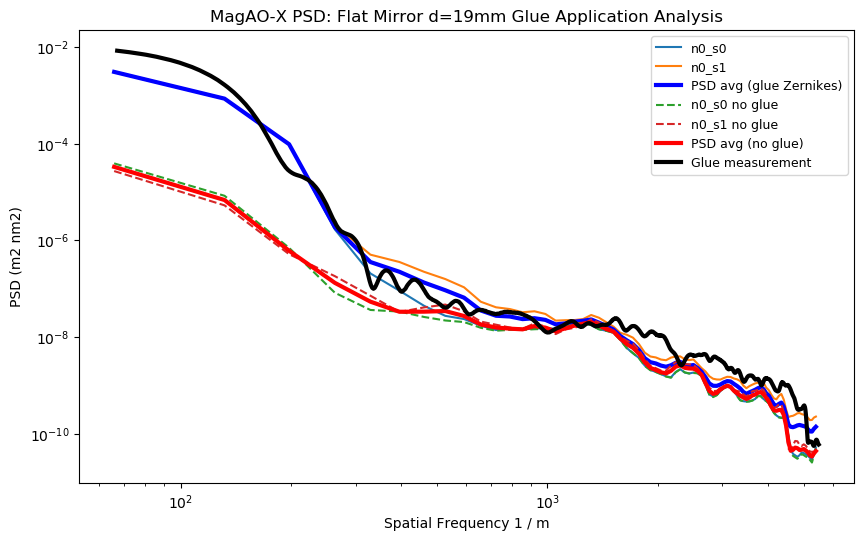

In [44]:
plt.figure(figsize=[10,6], dpi=100)
for nf in range(0, tot_fm):
    for ns in range(0, n_step):
        plt.loglog(ptt_k_radial[nf][ns].value, ptt_psd_radial[nf][ns].value, 
                   label='n{1}_s{2}'.format(nt_glue, nf,ns))
plt.loglog(ptt_avg_k_radial, ptt_avg_psd_radial, 'b', linewidth=3, 
           label='PSD avg (glue Zernikes)')
for nf in range(0, tot_fm):
    for ns in range(0, n_step):
        plt.loglog(ptt_k_radial2[nf][ns].value, ptt_psd_radial2[nf][ns].value, '--', 
                   label='n{1}_s{2} no glue'.format(nt_glue, nf,ns))
plt.loglog(ptt_avg_k_radial2, ptt_avg_psd_radial2, 'r', linewidth=3, 
           label='PSD avg (no glue)')
plt.loglog(avg_psd.k_radial.value, avg_psd.psd_radial_cal.value, 'k', linewidth=3, 
           label='Glue measurement')
plt.xlabel('Spatial Frequency {0}'.format(fm_dk.unit))
plt.ylabel('PSD ({0})'.format(fm_psd.unit))
plt.title('MagAO-X PSD: Flat Mirror d={0} Glue Application Analysis'.format(opt_parms['label']))
plt.legend(prop={'size':9})#,loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
# Write average PSD to file for easy access during modeling in separate notebook
hdr = fits.Header()
hdr['psd_unit'] = (str(psd_avg.unit), 'Units for PSD data')
hdr['wavelen'] = (opt_parms['wavelen'].value, 
                  'Wavelenth used in optical test [{0}]'.format(opt_parms['wavelen'].unit))
hdr['diam_ca'] = (opt_parms['diam_ca'].value, 
                  'Physical diameter for clear aperture [{0}]'.format(opt_parms['diam_ca'].unit))
hdr['diam_pix'] = (mask.shape[0],
                  'Pixel diameter for clear aperture')
hdr['clear_ap'] = (opt_parms['ca'],
                  'Clear aperture [percent]')
hdr['delta_k'] = (fm_dk.value,
                  'Spatial frequency lateral resolution [{0}]'.format(fm_dk.unit))
hdr['k_min'] = (1/opt_parms['diam_ca'].value,
                'Minimum spatial frequency boundary [{0}]'.format(fm_dk.unit))
hdr['k_max'] = (1/(2*opt_parms['diam_ca'].value/mask.shape[0]),
                'Maximum spatial frequency boundary [{0}]'.format(fm_dk.unit))
hdr['comment'] = 'If delta_k and k_min look like the same number, it is coincidence.'
hdr['comment'] = 'Note: delta_k is calculated from Lomb-Scargle, not the FFT oversample.'

psd_folder = 'flat_mirrors/mvls_psd/'
avg_psd_filename = psd_folder + 'lspsd_fm_{0}_avg_z{1}.fits'.format(opt_parms['label'], nt_ptt)
fits.writeto(avg_psd_filename, psd_avg.value, hdr, overwrite=True)